# Obtaining Data

In [3]:
#Importing libraries needed
import pandas as pd
import numpy as np


#For graphing 
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import shap

# For our modeling steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb 
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn import svm, datasets
from sklearn import metrics



# For demonstrative pruposes
from scipy.special import logit, expit

import warnings
warnings.filterwarnings('ignore')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [4]:
#opening the datasets 
bottom =  pd.read_csv(r'data\bottom_hurricane.csv')
middle =  pd.read_csv(r'data\middle_hurricane.csv')
top =  pd.read_csv(r'data\top_hurricane.csv')
all_df = pd.read_csv(r'data\all_hurricane.csv')

# Data Processing

In [5]:
#let's get rid of duplicate cities by only grabbing the cities with the max value for AWND
bottom = bottom.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
middle = middle.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
top = top.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City']).sort_index()
all_df = all_df.sort_values('AWND', ascending=False).drop_duplicates(['HurricaneName', 'City', 'DATE']).sort_index()

In [6]:
#We want to use data from hurricane Ian to test our mode
#let's save a dataframe that has just Ian 
all_ian = all_df.loc[all_df['HurricaneName'] == 'ian']
all_ian.head()

,City,HurricaneName,DATE,AWND,WSF2,SizeRank,before,after,percent,increase
3,Apalachicola,ian,9/28/2022,38.027300,57.93571,12877,65287.07867,76710.34737,17.496982,1
98,Fort Pierce,ian,9/28/2022,50.039453,100.66050,529,79706.02938,93971.25035,17.897292,1
179,Lakeland,ian,9/28/2022,51.538176,105.13430,105,92333.43871,109089.32580,18.147149,1
188,Leesburg,ian,9/29/2022,48.540730,91.48921,1024,89188.23594,102166.59930,14.551654,1
203,Miami,ian,9/28/2022,41.539233,69.56759,20,187941.97110,204898.39500,9.022159,0


In [7]:
#removing ian from the other datasets
bottom = bottom.drop(bottom[bottom['HurricaneName'] == 'ian'].index)
middle = middle.drop(middle[middle['HurricaneName'] == 'ian'].index)
top = top.drop(top[top['HurricaneName'] == 'ian'].index)
all_df = all_df.drop(all_df[all_df['HurricaneName'] == 'ian'].index)

In [8]:
#saving the all dataset for use in later analysis 
all_df.to_csv(r'data\wind_modeling.csv', index=False)

## Comparing Crosstabs by Target Variable

### Bottom Tier Home Values

In [9]:
#check crosstabs 
bottom[bottom['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,16.828333,31.587500,778.479167,95519.992225,109226.353419,15.737500,0.0
std,7.510509,13.880939,1933.043703,36589.222256,38580.694737,7.428945,0.0
min,4.700000,0.000000,12.000000,35072.914710,42936.584540,1.715556,0.0
25%,12.750000,23.000000,109.000000,67085.771493,77117.054463,9.294061,0.0
50%,14.430000,26.950000,219.000000,87921.154230,106197.766650,13.545954,0.0
75%,19.460000,36.000000,714.000000,124777.238250,137188.222700,21.427859,0.0
max,40.260000,79.000000,12877.000000,187941.971100,204898.395000,31.148843,0.0


In [10]:
#check crosstabs 
bottom[bottom['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,45.00000,45.000000,45.000000,45.000000,45.000000,45.000000,45.0
mean,19.71000,36.360000,1614.733333,81869.675339,99918.350911,22.208175,1.0
std,7.55599,14.072933,3251.236781,22972.899025,28216.775660,6.973273,0.0
min,5.82000,13.000000,12.000000,33025.679010,41196.088340,12.376811,1.0
25%,13.87000,25.900000,105.000000,65732.062590,78209.741850,17.496982,1.0
50%,19.46000,31.100000,350.000000,79706.029380,97547.957590,19.823318,1.0
75%,23.71000,52.100000,1343.000000,94132.640630,113361.292200,24.912005,1.0
max,40.71000,70.900000,12877.000000,137614.499600,166366.441400,38.720009,1.0


### Middle Tier Home Values

In [11]:
#check crosstabs 
middle[middle['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.0
mean,17.192736,32.578302,1196.764151,178788.700647,200015.445600,12.739620,0.0
std,7.398756,13.286456,2875.059325,57253.054213,60012.616564,8.166830,0.0
min,4.700000,10.100000,12.000000,47433.413480,55475.026340,-0.304135,0.0
25%,12.750000,23.900000,106.000000,140195.814075,158385.796575,6.516116,0.0
50%,14.760000,29.100000,219.000000,168077.713500,188779.652850,10.175417,0.0
75%,20.525000,36.900000,744.000000,214175.896200,235810.160275,19.340890,0.0
max,38.920000,79.000000,12877.000000,328091.109800,346404.378100,30.423110,0.0


In [12]:
#check crosstabs 
middle[middle['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.0
mean,19.468182,33.951515,2376.212121,152609.677086,183012.972018,19.750077,1.0
std,9.052282,16.306749,3966.086317,45215.695236,58301.939354,9.054438,0.0
min,4.470000,0.000000,12.000000,38971.285380,48205.342730,8.693131,1.0
25%,13.650000,23.900000,299.000000,131341.028200,147305.080700,11.724797,1.0
50%,16.780000,30.000000,529.000000,153995.650000,185899.410500,14.943632,1.0
75%,24.610000,46.100000,1644.000000,184197.828400,211150.410200,27.524342,1.0
max,40.710000,70.900000,12877.000000,237636.125500,316361.491800,34.925821,1.0


### Top Tier Home Values

In [13]:
#check crosstabs 
top[top['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0
mean,17.763947,33.115789,1225.184211,328449.969281,360988.239664,10.473163,0.0
std,7.852753,13.802145,2961.979981,113947.912364,122569.498236,8.631772,0.0
min,4.470000,8.100000,12.000000,98118.000900,119490.997200,-4.161603,0.0
25%,12.970000,23.900000,93.000000,246799.050675,271226.589675,4.737962,0.0
50%,15.100000,29.100000,190.000000,315968.313150,350767.209850,5.958488,0.0
75%,20.800000,38.000000,744.000000,382389.195500,418708.970725,17.504185,0.0
max,40.260000,79.000000,12877.000000,671004.028700,768214.341700,27.655345,0.0


In [14]:
#check crosstabs 
top[top['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.0
mean,17.624286,32.192857,2354.142857,273379.316779,326346.226943,18.132019,1.0
std,7.603506,14.464181,3809.242403,76774.203448,110181.403979,10.229255,0.0
min,5.820000,13.000000,16.000000,130756.896600,140391.373400,6.722834,1.0
25%,13.142500,23.675000,299.000000,231229.432300,255309.653800,7.967553,1.0
50%,14.875000,28.000000,636.500000,252692.063600,311156.525200,18.205906,1.0
75%,21.922500,34.325000,1927.000000,315217.170000,372749.758575,28.046185,1.0
max,40.710000,70.900000,12877.000000,457389.673300,605350.754900,33.863819,1.0


### All Home Values 

In [15]:
#check crosstabs 
all_df[all_df['increase'] == 0].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.0
mean,13.768992,27.177907,1191.391473,212575.987928,234000.852403,11.890184,0.0
std,6.939955,12.531378,2873.375161,124254.783285,131099.520669,8.078201,0.0
min,2.910000,0.000000,12.000000,45314.651590,52157.021900,-4.161603,0.0
25%,8.720000,18.100000,106.000000,117276.771100,135580.557625,5.582217,0.0
50%,12.190000,23.900000,219.000000,184998.996100,205368.325550,9.188158,0.0
75%,16.722500,31.100000,744.000000,278446.944025,311384.740025,17.445984,0.0
max,38.920000,79.000000,12877.000000,638691.713200,669502.004200,30.676022,0.0


In [16]:
#check crosstabs 
all_df[all_df['increase'] == 1].describe()

,AWND,WSF2,SizeRank,before,after,percent,increase
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.0
mean,14.880814,27.886047,1861.965116,146638.094252,174430.381725,19.463055,1.0
std,7.205503,13.217672,3396.683491,83327.546857,100276.415300,8.625308,0.0
min,4.920000,6.900000,12.000000,44457.567490,55432.846820,6.722834,1.0
25%,9.282500,18.100000,107.750000,80030.413350,93270.193108,12.500773,1.0
50%,13.650000,24.500000,462.000000,126538.414750,148023.322150,17.719562,1.0
75%,18.570000,31.775000,1410.000000,190034.211300,219513.525825,25.149288,1.0
max,40.710000,70.900000,12877.000000,372909.443500,488064.017600,38.720009,1.0


# Baseline Model

## Examining Class Imbalance

In order to know what a good accuracy is for our models, we must know what the majority class percent is. This will tell us if our model performs any better than just selecting the majority class each time. 

|Dataset | Increase | No Increase | No Increase as Percent |
|---|---|---|---|
|Bottom Tier| 45 | 96| 68% |
|Middle Tier| 33 | 106 | 76% |
|Top Tier| 28 | 114 | 80% |
|All| 89 | 255 | 74% |

#### Bottom Tier Class Imabalance

0    96
1    45
Name: increase, dtype: int64
majority percent is 68.08510638297872 %


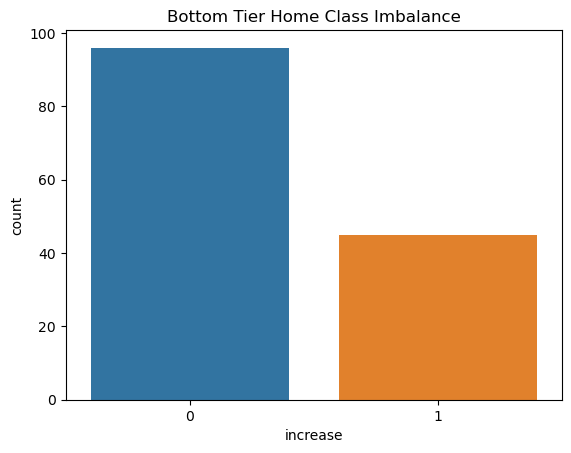

In [15]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=bottom).set(title='Bottom Tier Home Class Imbalance')
print(bottom['increase'].value_counts())
#checking ratio to see what accuracy is like
percent_bottom = (len(bottom['increase']) - bottom['increase'].sum())/(len(bottom['increase']) - bottom['increase'].sum()+bottom['increase'].sum())*100
print("majority percent is {}".format(percent_bottom),"%")


#### Middle Tier Class Imbalance

0    106
1     33
Name: increase, dtype: int64
majority percent is 76.2589928057554 %


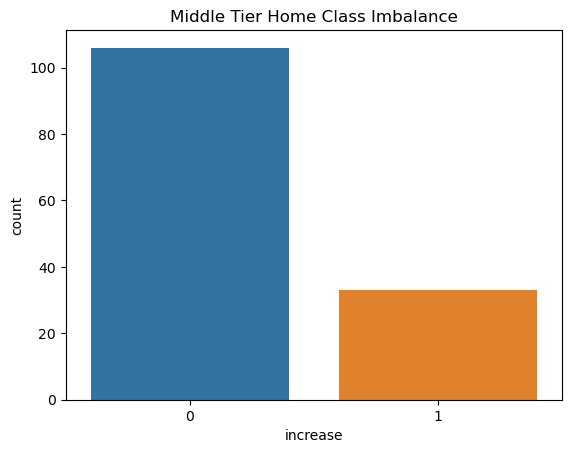

In [16]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=middle).set(title='Middle Tier Home Class Imbalance')
print(middle['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(middle['increase']) - middle['increase'].sum())/(len(middle['increase']) - middle['increase'].sum()+middle['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

#### Top Tier Class Imbalance

0    114
1     28
Name: increase, dtype: int64
majority percent is 80.28169014084507 %


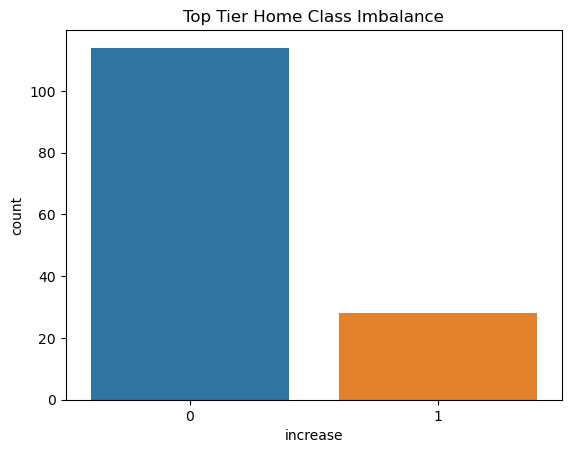

In [17]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=top).set(title='Top Tier Home Class Imbalance')
print(top['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(top['increase']) - top['increase'].sum())/(len(top['increase']) - top['increase'].sum()+top['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### All Homes Class Imbalance

0    258
1     86
Name: increase, dtype: int64
majority percent is 75.0 %


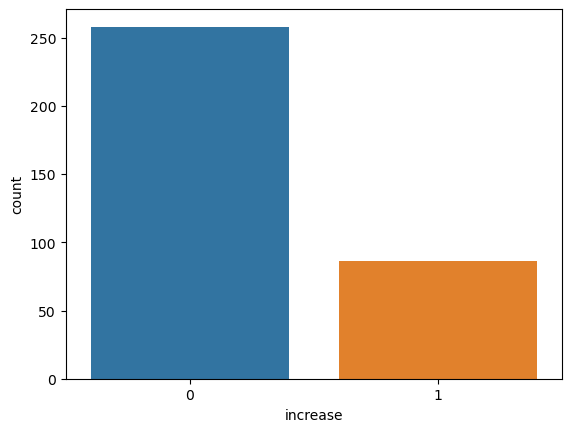

In [18]:
# Checking the balance of target variable 'increase'
sns.countplot(x='increase', data=all_df);
print(all_df['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_df['increase']) - all_df['increase'].sum())/(len(all_df['increase']) - all_df['increase'].sum()+all_df['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

# Modeling 

Of equal concern to the business problem was the model predicting False Negatives or False Positives. In this situation both are of equal importance to our real estate client. If the model predicts that the home value will not increase but it does (false negative) then our client could lose out on a possible higher return on a home. However, if the model predicts that the home value will increase but it does not (false positive) then our client may have invested money into a home that does not pay off. 

For the scope of this project we will be using accuracy and F1 score to assess our model performance. Since we had a class imbalance we could not solely rely on accuracy to communicate model performance. Since, precision and recall were of equal importance for our business problem F1 score was used to assess model performance. 

- **Model accuracy** is a machine learning classification model performance metric that takes the ratio of true positives and true negatives to all positives and negative results. It communicates how often our model will correctly predict an outcome out of the total number of predictions made. However, accuracy metrics are not always reliable for imbalance datasets. Accuracy Score = (TP + TN)/ (TP + FN + TN + FP)  

- **Model F1 Score** is a model performance metric that gives equal weight to both the Precision and Recall for measuring performance. F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)    

- **ROC-AUC** The Receiver Operator Characteristic (ROC) curve is used to assess a model’s ability to correctly classify by plotting the true positive rate against the false positive rate. A curve that ‘peaks’ more quickly communicates that there is a good true positive rate and a low false positive rate. The area under the curve (AUC) is derived from ROC and has a baseline chance of 50% accuracy, hence, an AUC closer to 1 signifies a better classification model.

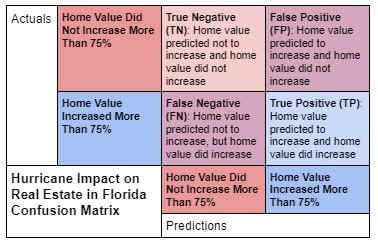

**Works Cited**   
Filho M. How To Get Feature Importance In Logistic Regression. forecastegy.com. Published March 30, 2023. Accessed July 10, 2023. https://forecastegy.com/posts/feature-importance-in-logistic-regression/#feature-importance-in-binary-logistic-regression     
Kumar A. Accuracy, Precision, Recall & F1-Score - Python Examples. Data Analytics. Published October 1, 2021. https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

### Logistic Regresion

A logistic regression model was iterated through with our scaled data. We removed collinear variables and used SMOTE to adjust for the class imbalance. The logistic regression model that performed the best was our SMOTE model with no colinear features and had an accuracy of 0.74 which was slightly better than our baseline accuracy of 0.68 and an F1 score of 0.68. 

In [19]:
#establishing model 
logreg = LogisticRegression(random_state=56)

## Model 1: Bottom Tier Housing

We will use the bottom tier housing for modeling since it has the best class imbalance. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our first iteration of modeling we will use all the available features. 

In [20]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [21]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [22]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

In [23]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [24]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [25]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

In [26]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [27]:
#Printing Accuracy
accuracy_1 = accuracy_score(y_test, y_pred_test)
print(accuracy_1)

0.7441860465116279


In [28]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_1 = f1_score(y_test, y_pred_test)
print(F1_1)

0.35294117647058826


In [29]:
#initiating dictionary to keep model accuracy and F1 score
model_dict = {}
#recording baseline model accuracy
model_dict['Baseline Accuracy'] = percent_bottom
#recording model 1 values
model_dict['LGRModel1_Accuracy'] = accuracy_1
model_dict['LGRModel1_F1'] = F1_1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826}

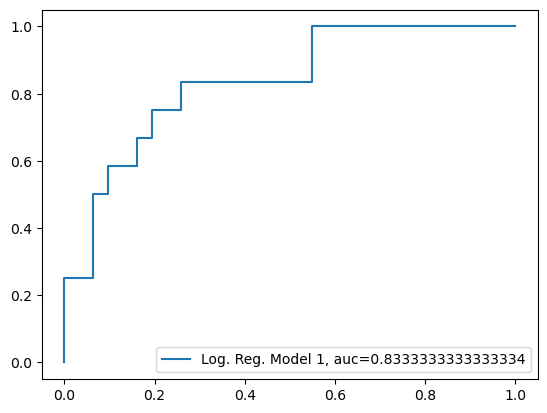

In [30]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

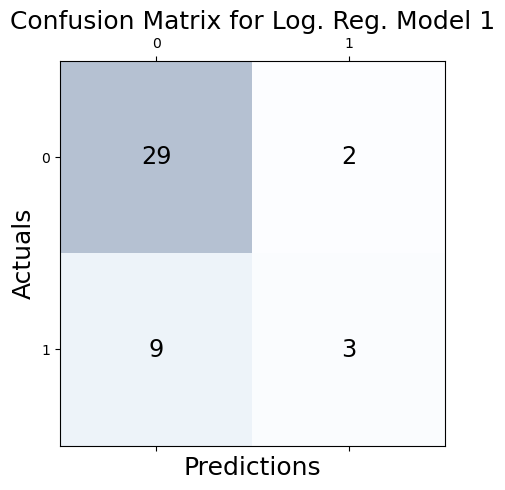

In [31]:
#getting confusion matrix values
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
#plotting
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
#assigning labels
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 1', fontsize=18)
plt.show()

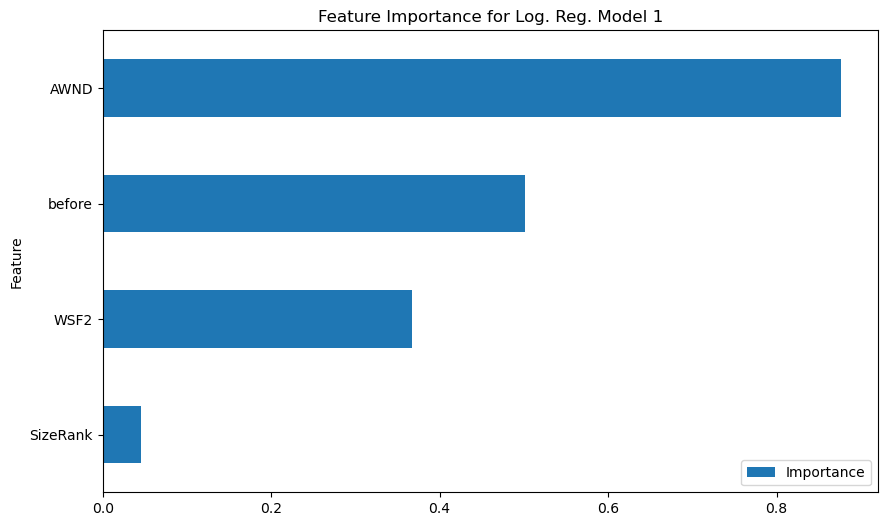

In [32]:
#checking out feature importance
#initiating model 
model = LogisticRegression()
#fitting model 
model.fit(X_train, y_train)
#getting coefficients 
coefficients = model.coef_[0]
#plotting 
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', title='Feature Importance for Log. Reg. Model 1', kind='barh', figsize=(10, 6));

## Model 2: Bottom Tier Housing Without Colinear Variables 

We will use the bottom tier housing for modeling since it has the best class imbalance. 

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [33]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'WSF2', 'increase'], axis=1)

### Train/Test Split

In [34]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [35]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### Training Data

In [36]:
#fitting the model unto our training data
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)

In [37]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_train, y_pred_train))

Accuracy: 0.684


In [38]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_train, y_pred_train))

F1 Score: 0.311


### Testing Data

In [39]:
#fitting the model unto our test data
logreg.fit(X_test, y_test)
y_pred_test = logreg.predict(X_test)

In [40]:
#Printing Accuracy
accuracy_2 = accuracy_score(y_test, y_pred_test)
print(accuracy_2)

0.7674418604651163


In [41]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_2 = f1_score(y_test, y_pred_test)
print(F1_2)

0.375


### Saving to Dictionary

In [42]:
#adding to model dictionary
model_dict['LGRModel2_Accuracy'] = accuracy_2
model_dict['LGRModel2_F1'] = F1_2
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375}

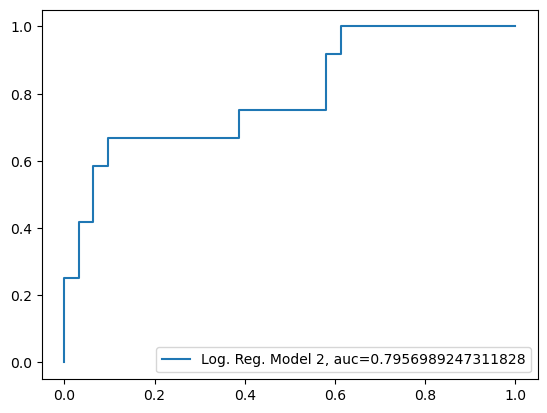

In [43]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 2, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

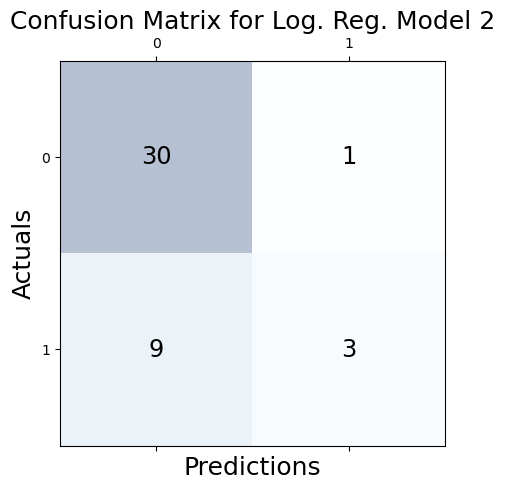

In [44]:
#getting confusion matrix values
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
#plotting 
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
#assigning labels 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 2', fontsize=18)
plt.show()

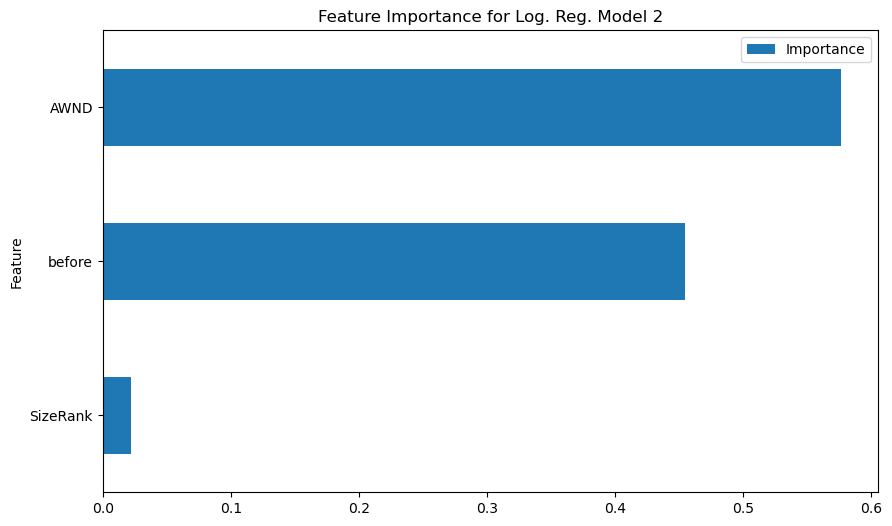

In [45]:
#initiating model
model = LogisticRegression()
#fitting model
model.fit(X_train, y_train)
#getting coefficients
coefficients = model.coef_[0]
#plotting
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 2', figsize=(10, 6));

## Model 3: Bottom Tier Housing with Smote 

In [46]:
#y is prediction variable 
#X is features 
y = bottom['increase']
X = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase', 'WSF2'], axis=1)

### Train/Test Split

In [47]:
#performing train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=56)

### Scaling Our Data

In [48]:
#initiating Standard Scaler
sc = StandardScaler()
#fitting
sc.fit(X_train)
#tranforming X train and test
X_train = sc.transform(X_train)
X_test= sc.transform(X_test)

### SMOTE

In [49]:
# Create instance of smotec
from imblearn.over_sampling import SMOTE,SMOTENC
# set sampling_strategy to 0.8 to avoid oversampling
smote = SMOTE(sampling_strategy=0.8, random_state=56)

In [50]:
# Create resampled version of the train dataset
SMOTE_X_train, SMOTE_y_train = smote.fit_resample(X_train, y_train)
# Create resampled version of the test dataset
SMOTE_X_test, SMOTE_y_test = smote.fit_resample(X_test, y_test)

In [51]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', SMOTE_y_train.value_counts())

Before Smote
 0    65
1    33
Name: increase, dtype: int64

After Smote
 0    65
1    52
Name: increase, dtype: int64


### Training Data

In [52]:
#fitting the model unto our training data
logreg.fit(SMOTE_X_train, SMOTE_y_train)
y_pred_train = logreg.predict(SMOTE_X_train)

#### Checking Metrics

In [53]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(SMOTE_y_train, y_pred_train))

Accuracy: 0.641


In [54]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(SMOTE_y_train, y_pred_train))

F1 Score: 0.553


### Testing Data

In [55]:
#fitting the model unto our test data
logreg.fit(SMOTE_X_test, SMOTE_y_test)
y_pred_test = logreg.predict(SMOTE_X_test)

#### Checking Metrics

In [56]:
#Printing Accuracy
accuracy_3 = accuracy_score(SMOTE_y_test, y_pred_test)
print(accuracy_3)

0.7454545454545455


In [57]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_3 = f1_score(SMOTE_y_test, y_pred_test)
print(F1_3)

0.6818181818181818


In [58]:
#adding metrics to dictionary
model_dict['LGRModel3_Accuracy'] = accuracy_3
model_dict['LGRModel3_F1'] = F1_3
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818}

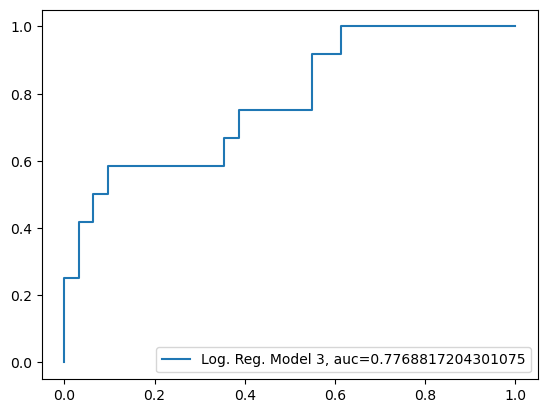

In [59]:
#let's check out the AUC curve
#getting probability
y_pred_prob = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="Log. Reg. Model 3, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Confusion Matrix

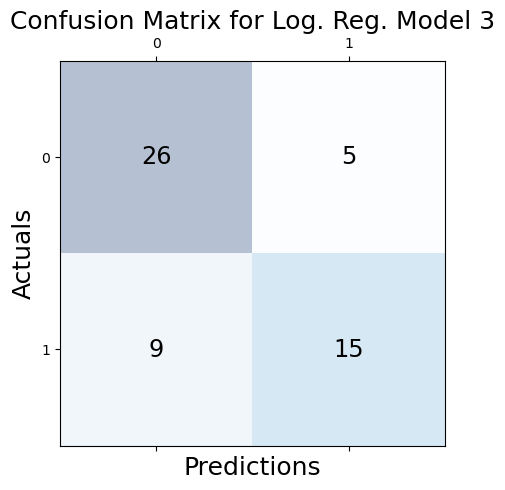

In [60]:
#getting confusion matrix values
conf_matrix = confusion_matrix(y_true=SMOTE_y_test, y_pred=y_pred_test)
#plotting
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
#assigning labels 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Log. Reg. Model 3', fontsize=18)
plt.show()

### Feature Importance

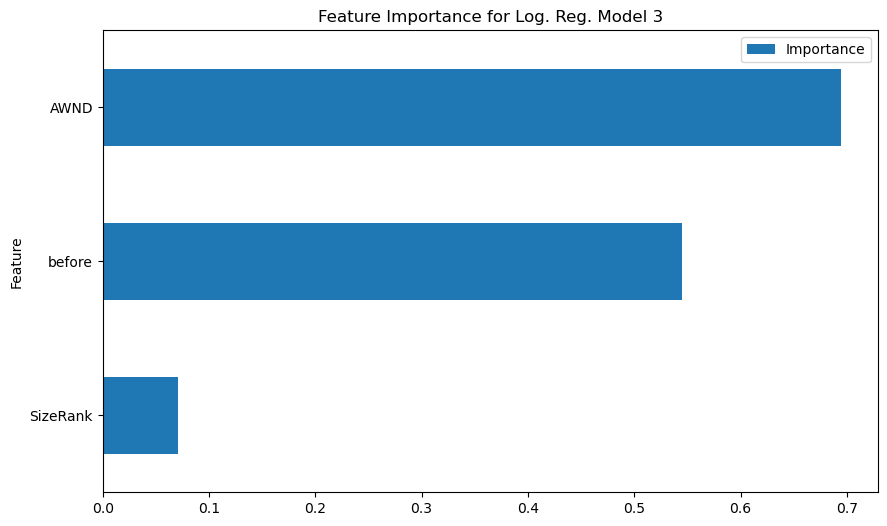

In [61]:
#initiating model 
model = LogisticRegression()
#fitting model 
model.fit(SMOTE_X_train, SMOTE_y_train)
#getting coefficients 
coefficients = model.coef_[0]
#plotting feature_importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title= 'Feature Importance for Log. Reg. Model 3', figsize=(10, 6));

## XGBoost

In [62]:
#initiating model
xgb = XGBClassifier(random_state=56)

### Selecting Our Target Variable and Features

In [63]:
#y is prediction variable 
#X is features 
y_boost = bottom['increase']
X_boost = bottom.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

### Train/Test Split

In [64]:
#train/test splits with 30% test size
XG_X_train, XG_X_test, XG_y_train, XG_y_test = train_test_split(X_boost, y_boost, test_size=0.30, random_state=56)

### Training Data

In [65]:
#fitting the model 
xgb.fit(XG_X_train, XG_y_train);

In [66]:
#getting predictions
y_pred_train = xgb.predict(XG_X_train)

In [67]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(XG_y_train, y_pred_train))

Accuracy: 1.000


In [68]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(XG_y_train, y_pred_train))

F1 Score: 1.000


### Testing Data

In [69]:
#fitting the model 
xgb.fit(XG_X_test, XG_y_test);

In [70]:
#getting predictions 
y_pred_test = xgb.predict(XG_X_test)

In [71]:
#Printing Accuracy
accuracy_XG1 = accuracy_score(XG_y_test, y_pred_test)
print(accuracy_XG1)

1.0


In [72]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
F1_XG1 = f1_score(XG_y_test, y_pred_test)
print(F1_XG1)

1.0


In [73]:
#adding values to dictionary
model_dict['XGBoost_Accuracy'] = accuracy_XG1
model_dict['XGBoost_F1'] = F1_XG1
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0}

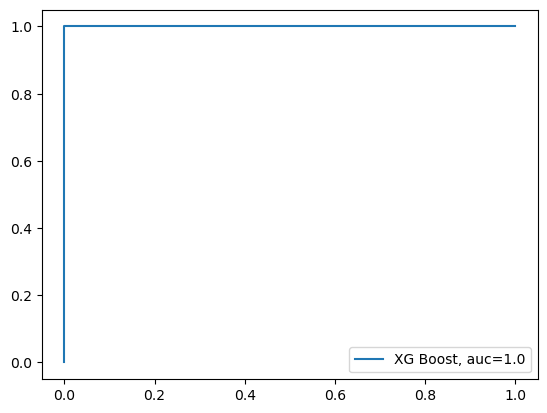

In [74]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(XG_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(XG_y_test,  y_pred_prob)
auc = metrics.roc_auc_score(XG_y_test, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost, auc="+str(auc))
plt.legend(loc=4)
plt.show()

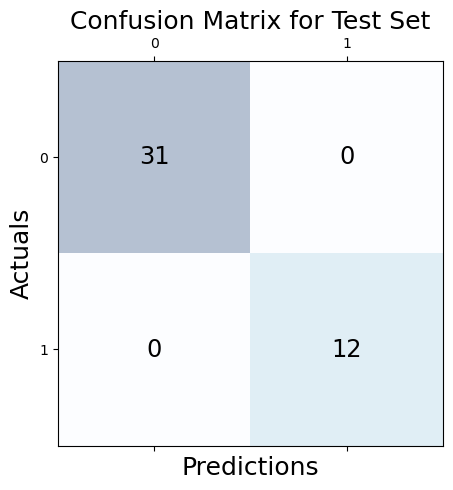

In [75]:
#checking confusion matrix
conf_matrix = confusion_matrix(y_true=XG_y_test, y_pred=y_pred_test)

#plotting confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
#assigning labels 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Test Set', fontsize=18)
plt.show()

## SHAP (SHapley Additive exPlanations) 

SHAP is used to explain the output of machine learning models. Using a beeswarm plot can reveal the importance of features and their relationship with the predicted outcome. 

shap_values: is the average contribution of each of the features to the prediction for each sample based on alll the possible features. 

From the plot below we can interpret that:
- larger SizeRank values have a higher impact on feature value     
- smaller before values have a higher impact on feature value      
- higher WSF2 and AWND values have higher impact on feature value      

Works Cited   
Classification Feature Selection : SHAP Tutorial. kaggle.com. Accessed July 6, 2023. https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial#SHAP


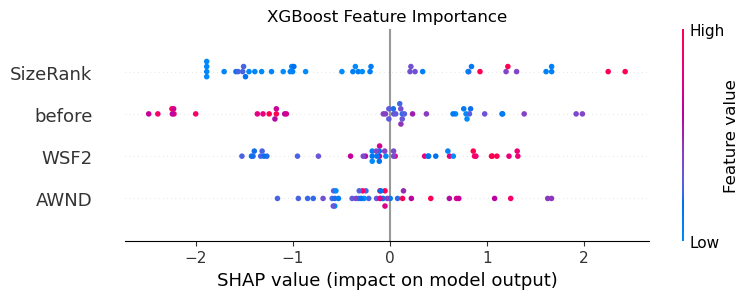

In [76]:
#Using SHAP to assess feature importance 
#creating an explainer for our model
explainer = shap.TreeExplainer(xgb)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(XG_X_test)

#creating a beeswarm plot 
shap.initjs()
plt.title("XGBoost Feature Importance", y=1)
shap.summary_plot(shap_values, XG_X_test)

# Best Model: XGBoost
We ran two types of models, logistic regression and XG Boost. The best logisitc regression model (model 3 with SMOTE) had an accuracy of 74% which is only slightly better than the majority percent of 68% and an F1 score of 0.68. Our best model was XGBoost which had a perfect accuracy and F1 score with the included features:
- AWND
- WSF2
- SizeRank
- before 

In [77]:
#pulling up model accuracy and F1 score for all models 
model_dict

{'Baseline Accuracy': 68.08510638297872,
 'LGRModel1_Accuracy': 0.7441860465116279,
 'LGRModel1_F1': 0.35294117647058826,
 'LGRModel2_Accuracy': 0.7674418604651163,
 'LGRModel2_F1': 0.375,
 'LGRModel3_Accuracy': 0.7454545454545455,
 'LGRModel3_F1': 0.6818181818181818,
 'XGBoost_Accuracy': 1.0,
 'XGBoost_F1': 1.0}

# Model Validation 

## XGBoost on Hurricane Ian Data

0    16
1    11
Name: increase, dtype: int64
majority percent is 59.25925925925925 %


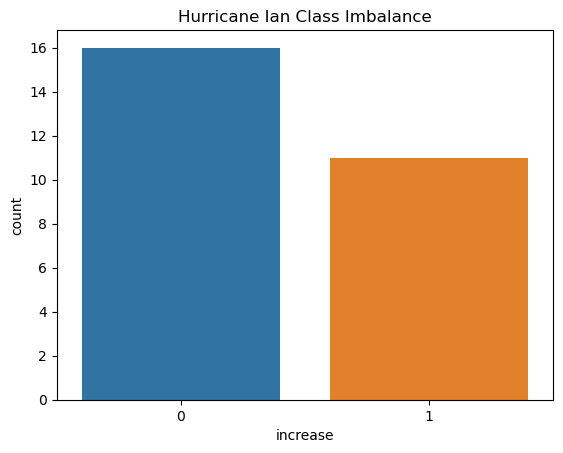

In [78]:
# Checking the balance of target variable 'increase'
#plotting 
sns.countplot(x='increase', data=all_ian).set(title='Hurricane Ian Class Imbalance')
#print value counts 
print(all_ian['increase'].value_counts())
#checking ratio to see what accuracy is like
percent = (len(all_ian['increase']) - all_ian['increase'].sum())/(len(all_ian['increase']) - all_ian['increase'].sum()+all_ian['increase'].sum())*100
print("majority percent is {}".format(percent),"%")

### Selecting Our Target Variable and Features
Our targer variable is increase and for our second iteration of modeling we will drop WSF2 because it's highly correlated with AWND. 

In [79]:
#y is target variable 
#X is features 
y_ian = all_ian['increase']
X_ian = all_ian.drop(['City', 'HurricaneName', 'DATE', 'after', 'percent', 'increase'], axis=1)

In [80]:
#getting prediction
y_pred = xgb.predict(X_ian)

In [81]:
#Printing Accuracy
print('Accuracy: %.3f' % accuracy_score(y_ian, y_pred))

Accuracy: 0.741


In [82]:
#using F-1 score to see how it performs
#F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score/)
print('F1 Score: %.3f' % f1_score(y_ian, y_pred))

F1 Score: 0.533


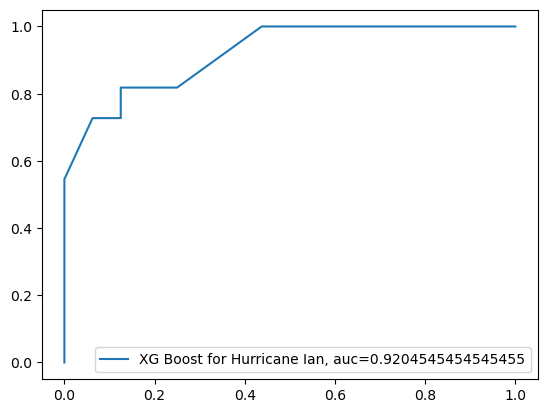

In [83]:
#let's check out the AUC curve
#getting probability
y_pred_prob = xgb.predict_proba(X_ian)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_ian,  y_pred_prob)
auc = metrics.roc_auc_score(y_ian, y_pred_prob)

#plotting
plt.plot(fpr,tpr,label="XG Boost for Hurricane Ian, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Confusion Matrix

As seen below 7 false negatives were predicted. Meaning home value was predicted not to increase, but it did. 

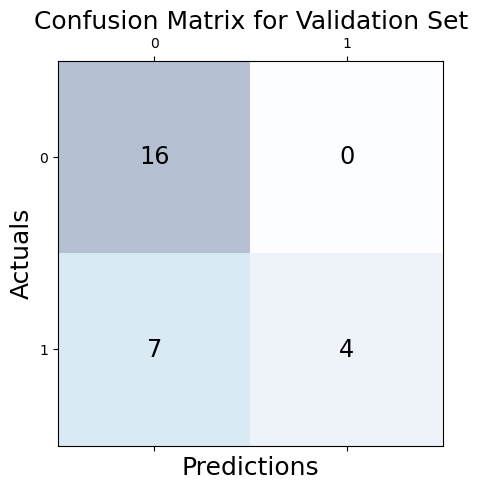

In [84]:
conf_matrix = confusion_matrix(y_true=y_ian, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Validation Set', fontsize=18)
plt.show()